#Code for ViViT model [[paper]](https://arxiv.org/abs/2103.15691)


## Imports and Global declarations

In [1]:
# Imports

import torch
from torch import nn, einsum
from torch.nn import functional as F
from torch.utils.tensorboard import SummaryWriter
import torchvision as tv
from torch.utils.data import random_split, DataLoader,Dataset

import os
import time
import random
import math

# !pip install einops icecream
import decord
import numpy as np
import gc
from einops import rearrange, repeat,reduce
from einops.layers.torch import Rearrange
from PIL import Image
from tqdm.notebook import tqdm
from icecream import ic
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# set device
device ='cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [3]:
# Instantiate tensorboard writer
#tb_writer = SummaryWriter()

## DataLoader for UCF101 dataset 

In [4]:
# dataset params
frames_per_clip = 8
dataset_dir="./ucf/UCF101TrainTestSplits-RecognitionTask/ucfTrainTestlist"
video_dir = "./ucf/UCF101/UCF-101"

In [5]:
# Dataset Class
class UCFDataset(torch.utils.data.Dataset):
    """
    Dataset Class for reading UCF101 dataset  
    
    Args:
        dataset_dir: (str) - root directory of dataset
        subset: (str) - train or test subset
        video_list_file: (str) - file name containing list of video names 
        frames_per_clip: (int) - number of frames to be read in every video clip [default:16]
    """

    def __init__(self, dataset_dir, subset, video_list_file, frames_per_clip=16):
        super().__init__()
        self.dataset_dir = dataset_dir
        self.video_dir = video_dir
        self.subset=subset
        self.video_list_file = video_list_file
        self.video_list = []
        self.labels = []
        self.indices = []

        for i in [1,2,3]:
            with open(f'{dataset_dir}/{video_list_file}{str(i)}.txt') as video_names_file:
                if self.subset=="train":
                    tempvideo_list,templabels = zip(*(files[:-1].split() for files in video_names_file.readlines()))
                    self.video_list += tempvideo_list
                    self.labels += templabels
                else:
                    tempvideo_list = [files[:-1] for files in video_names_file.readlines()]
                    templabels = [None]
                    self.video_list += tempvideo_list
                    self.labels += templabels
                    # with open(f'{dataset_dir}/classInd.txt') as classIndices:
                    #     values,keys=zip(*(files[:-1].split() for files in classIndices.readlines()))
                    #     tempindices = dict( (k,v) for k,v in zip(keys,values))
                    
            
            #self.indices.append(tempindices)
        

        self.frames_per_clip = frames_per_clip

        self.transform = tv.transforms.Compose([
          #tv.transforms.GaussianBlur(9, sigma=(0.1, 2.0)),
          tv.transforms.Resize(256,interpolation=tv.transforms.InterpolationMode.BICUBIC),
          tv.transforms.CenterCrop(224),
          tv.transforms.ToTensor(),
          tv.transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ])

    def __len__(self):
        return len(self.video_list)

    def __getitem__(self, idx):
        videoname = f'{self.video_list[idx]}'
        vid = decord.VideoReader(f'{self.video_dir}/{videoname}', ctx=decord.cpu(0))
        nframes = len(vid)

        # if number of frames of video is less than frames_per_clip, repeat the frames
        if nframes <= self.frames_per_clip:
            idxs = np.arange(0, self.frames_per_clip).astype(np.int32)
            idxs[nframes:] %= nframes

        # else if frames_per_clip is greater, sample uniformly seperated frames
        else:
            idxs = np.linspace(0, nframes-1, self.frames_per_clip)
            idxs = np.round(idxs).astype(np.int32)

        imgs = []
        for k in idxs:
            frame = Image.fromarray(vid[k].asnumpy())
            frame = self.transform(frame)
            imgs.append(frame)
        imgs = torch.stack(imgs)

        # if its train subset, return both the frames and the label 
        if self.subset=="train":
            label = int(self.labels[idx]) - 1    
        # else, for test subset, read the label index
        else:
            classttl = {}
            with open(f'{dataset_dir}/classInd.txt') as clsidx:
                
                classttl = {v:int(k) for k, v in (l.split() for l in clsidx)}

            clsname = videoname.split('/')[0]
            label= classttl[clsname] -1
        return imgs,label

In [6]:
#Instantiate and create train-val-test split

train_val_data = UCFDataset( dataset_dir = dataset_dir, subset="train", video_list_file="trainlist0",frames_per_clip=frames_per_clip)

train_len=int(0.85*len(train_val_data))
train_val_split = [ train_len, len(train_val_data) - train_len ] 

train_data , val_data = random_split(train_val_data,train_val_split)
test_data = UCFDataset( dataset_dir = dataset_dir, subset="test", video_list_file="testlist0" ,frames_per_clip=frames_per_clip)

print(f"Train samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")
print(f"Test samples: {len(test_data)}")


Train samples: 24434
Validation samples: 4313
Test samples: 11213


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([8, 3, 224, 224])
94


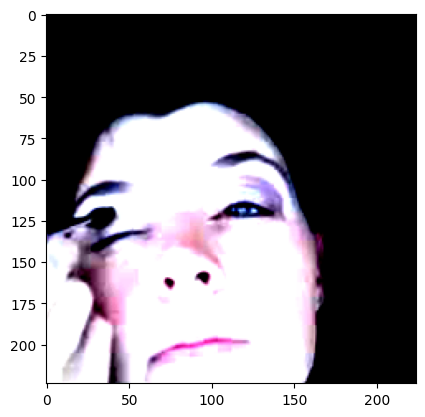

In [7]:
#example frame from a random video to check if dataloader's working properly
plt.imshow(((test_data[35][0][0].permute(1,2,0)*255).int()).numpy())
print(train_data[35][0].shape)  #Size([8, 3, 224, 224])
print(train_data[35][1])        # label

In [8]:
# data loading params
batch_size = 64
test_batch_size = 1
num_workers = 8
pin_memory = True
num_classes=101

In [9]:
# Dataloaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=test_batch_size)

## Model definition

In [10]:
class MLP(nn.Module):
    """
    Builds a simple feed forward network
    
    Args:
        dim: (int) - inner dimension of| embeddings 
        inner_dim: (int) - dimension of transformer head  
    
    """

    def __init__(self, dim, inner_dim,n_class,encoder):     #dim would be the output image feature from dinov2
                                                        
        super().__init__()
        # mlp with GELU activation function
        self.encoder = encoder
        self.mlp = nn.Sequential(
            #nn.Linear(dim, inner_dim),
            #nn.GELU(),
            #nn.Dropout(0.5),
            #nn.Linear(inner_dim, inner_dim),
            #nn.GELU(),
            nn.Linear(dim, n_class),
            #nn.Dropout(0.5)
        )

    def forward(self, x):
        # x is [256,8,3,224,224]
        
        #print('x shape is',x.shape)
        # avg = []
        
        # for i in range(8):
        #     xi = x[:,i,:]
            
        #     #encode x to [8,384]
        #     e = []
        #     with torch.no_grad():
        #         # features_dict = self.encoder.forward_features(xi)
        #         # e = features_dict['x_norm_patchtokens']
        #         e = self.encoder(xi).reshape(x.shape[0],1,384)
        #     print('e shape ',e.shape)   #256,1,384
        #     avg.append(e)
        # avg = torch.cat(avg,dim=1)    
        
               
        #avg = reduce(avg, "f t c -> f c",'mean')        #[16,384]   (b, l)

        with torch.no_grad():    
            B,T,C,H,W = x.shape
            x = x.reshape(B*T,C,H,W) # b c t h w -> b t c h w -> b*t c h w
            #print('x shape is',x.shape)
            output = self.encoder(x)
            output = output.reshape(B,T,-1) # b*t d -> b t d
            avg = output.mean(dim=-2) # b t d -> b d
        #output = linear_classifier(output) # b d -> b l
        #print(avg.shape)
        
        return self.mlp(avg)

In [14]:
# instantiate model and plot on tensorboard
#model = ViViT(image_size=224, patch_size=16, num_classes=num_classes, frames_per_clip=frames_per_clip)
dinov2_vits14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14',force_reload=True)
dinov2_vits14.to(device)
for param in dinov2_vits14.parameters():
    param.requires_grad= False
model = MLP(384,512,101,dinov2_vits14)
#frames, _ = next(iter(train_loader))
#tb_writer.add_graph(model, frames)
model.to(device)

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /home/z3qian/.cache/torch/hub/main.zip


MLP(
  (encoder): DinoVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
      (norm): Identity()
    )
    (blocks): ModuleList(
      (0-11): 12 x NestedTensorBlock(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): MemEffAttention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (drop_path1): Identity()
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=1536, out_features=384, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
        (

## Training utils 

In [15]:
# training hyper-params
lr=0.1
epochs = 5

In [16]:
# define the loss and optimizers
loss_criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, weight_decay=0,lr=lr)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 1_000_00, eta_min=0)
#optimizer = torch.optim.Adam(model.parameters(),lr)
optimizer = torch.optim.SGD(model.parameters(),lr=lr,momentum=0.9,weight_decay=0.01)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.95)


In [17]:
# training step for every epoch
def train_step(loader,epoch,):
    
    model.train()
    # model.encoder.eval()
    total_epoch_loss=0
    
    for batch_id, (video_data,labels) in enumerate(loader):

        # video_data,labels = video_data.to(device), labels.to(device)
        video_data,labels = video_data.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        prediction = model(video_data)

        loss = loss_criterion(prediction,labels)
        total_epoch_loss += loss.item()

        loss.backward()
        
        optimizer.step()
        corrects = (torch.argmax(prediction,dim=1)==labels).sum()
        bacc = corrects/batch_size
        del video_data
        del labels

        gc.collect()
        
        #tb_writer.add_scalar("Train/Loss",loss.item(),((len(loader))*(epoch-1))+batch_id)
        
        
        print(f"\n[Train Epoch]: {epoch} Train Loss: {loss.item()}, Batch Acc is {bacc.item()}")

    return total_epoch_loss

In [18]:
# validation step for every epoch
def val_step(loader,epoch=None):

    model.eval()
    total_loss=0
    corrects=0
    
    with torch.no_grad():
        for batch_id, (video_data,labels) in enumerate(loader):

            video_data,labels = (video_data).to(device), labels.to(device)

            prediction = model(video_data)
            
            loss = loss_criterion(prediction,labels)
            total_loss += loss.item()
            corrects+= (torch.argmax(prediction,dim=1)==labels).sum()
    
    accuracy = corrects/(len(loader)*batch_size)
    
    print(f"\n[Val Epoch]: {epoch} , Accuracy: {accuracy}, Valid Loss: {loss.item()}")
    #tb_writer.add_scalar("Validation/Loss",loss.item(),epoch)
    #tb_writer.add_scalar("Validation/Accuracy",accuracy,epoch)

    return accuracy

## Train Loop

In [19]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

mlp.0.weight
mlp.0.bias


In [20]:
# Driving train test loop
for epoch in tqdm(range(1,epochs+1)):
    train_step(train_loader, epoch)
    val_step(val_loader, epoch)
    #scheduler.step()
    torch.save(model,"dino_model.pth")

  0%|          | 0/20 [00:00<?, ?it/s]


[Train Epoch]: 1 Train Loss: 5.326816558837891, Batch Acc is 0.015625

[Train Epoch]: 1 Train Loss: 4.8318305015563965, Batch Acc is 0.046875

[Train Epoch]: 1 Train Loss: 3.602318286895752, Batch Acc is 0.28125

[Train Epoch]: 1 Train Loss: 3.0715742111206055, Batch Acc is 0.390625

[Train Epoch]: 1 Train Loss: 3.3045413494110107, Batch Acc is 0.40625

[Train Epoch]: 1 Train Loss: 2.8794362545013428, Batch Acc is 0.46875

[Train Epoch]: 1 Train Loss: 3.3950183391571045, Batch Acc is 0.46875

[Train Epoch]: 1 Train Loss: 2.476335287094116, Batch Acc is 0.546875

[Train Epoch]: 1 Train Loss: 2.5010993480682373, Batch Acc is 0.484375

[Train Epoch]: 1 Train Loss: 2.283100128173828, Batch Acc is 0.625

[Train Epoch]: 1 Train Loss: 1.4331538677215576, Batch Acc is 0.734375

[Train Epoch]: 1 Train Loss: 2.482462167739868, Batch Acc is 0.59375

[Train Epoch]: 1 Train Loss: 2.589104175567627, Batch Acc is 0.609375

[Train Epoch]: 1 Train Loss: 1.2699445486068726, Batch Acc is 0.71875

[Train

KeyboardInterrupt: 

In [ ]:
model = MLP(384,512,101,dinov2_vits14)
model.load_state_dict(torch.load('dino_model.pth'))
model.to(device)

TypeError: Expected state_dict to be dict-like, got <class '__main__.MLP'>.

## Testing

In [23]:
# test the trained model  
def test_model(loader):

    model.eval()
    corrects=0
    total_loss = 0
    with torch.no_grad():
        for batch_id, (input_data,labels) in enumerate(loader):
            
            input_data = input_data.to(device)
            
            labels = labels.to(device)
            prediction = model(input_data)
            loss = loss_criterion(prediction,labels)
            total_loss += loss.item()
            corrects+= (torch.argmax(prediction,dim=1)==labels).sum()
    
    accuracy = corrects/(len(loader)*test_batch_size)
    print(f"Test Accuracy: {accuracy}, Test Loss: {total_loss}")

    return accuracy

In [24]:

test_model(test_loader)

Test Accuracy: 0.8407205939292908, Test Loss: 11977.843482483195


tensor(0.8407, device='cuda:0')

## Visualize results on tensorboard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=runs/ 